# Übung 6: Kantendetektion und Hough Transformation

##  Kantendetektion mit Canny

Mit dem Canny Detektor können Kanten in einem Bild detektiert werden. Das von Canny bereits 1987 etnwickelte Verfahren betrachtet die Kantenerkennung als Optimisierungsproblem und besteht in der Anwendung im wesentlichen aus 3 Schritten:

- Ermittlung der Kantenstärke durch Ableitungsfilter
- Finden des lokalen Maxima senkrecht zur Kante
- Hysteresis Thresholding mit 2 Schwellwerten unter Berücksichtigung der Verbindungen zwischen den Pixeln


In [2]:
# OpenCV needs to be included first
import cv2
import numpy as np
import math

# for displaying images in jupyter

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 400

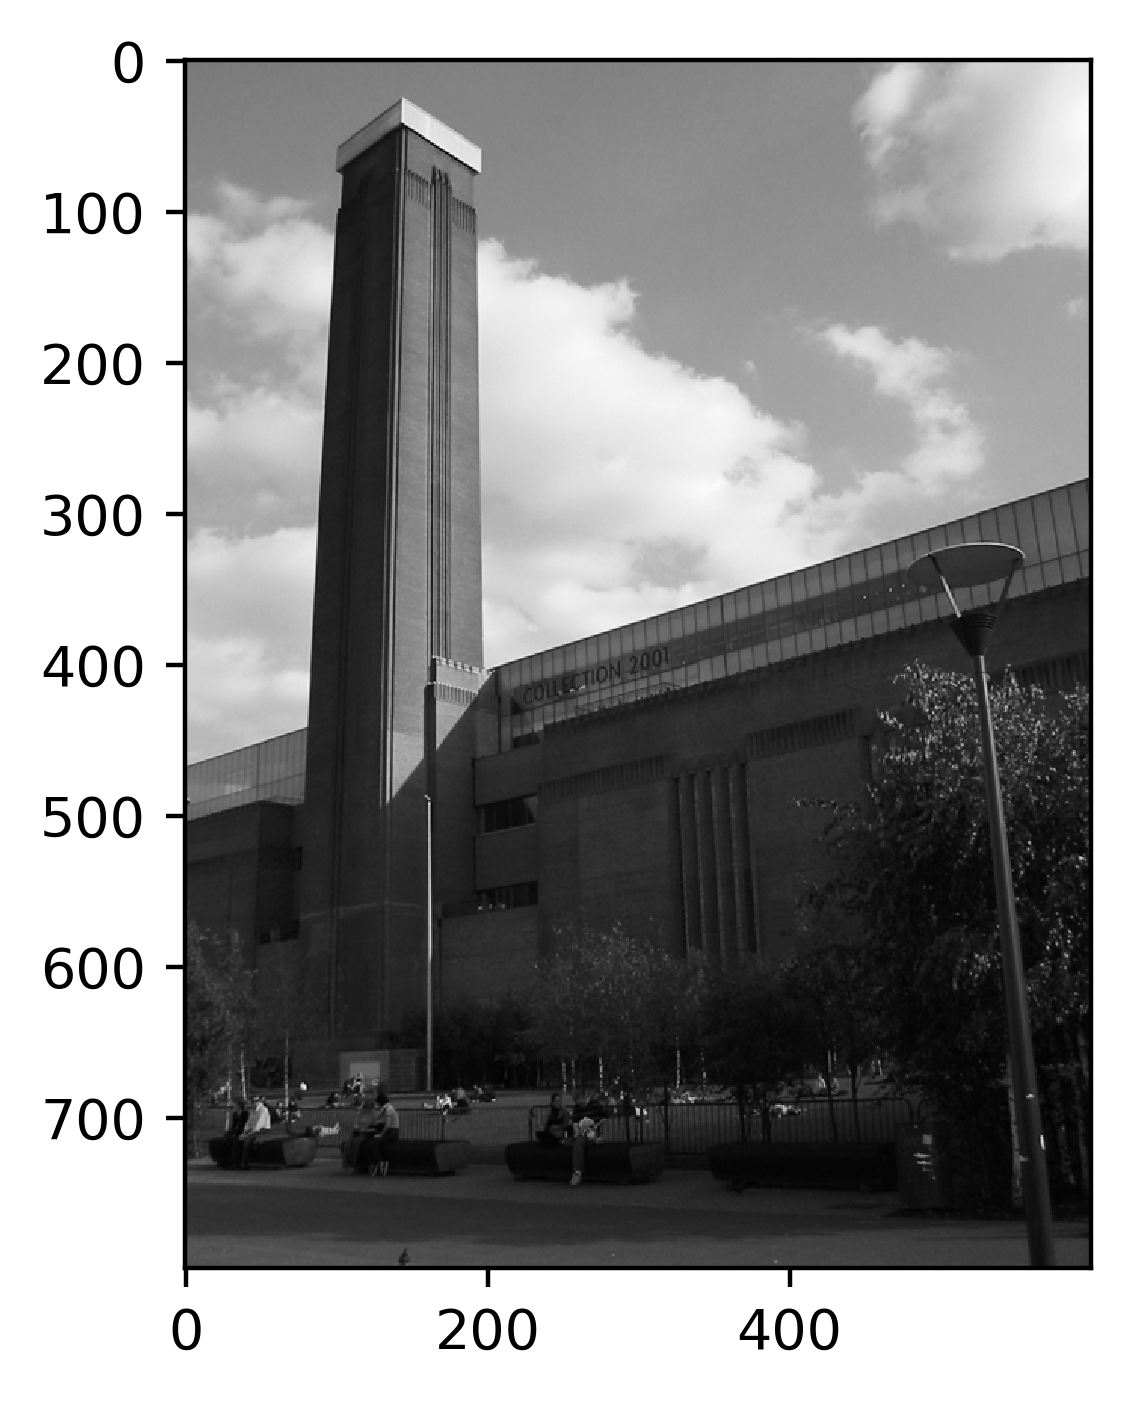

In [3]:
image  = cv2.imread('images/londonSmall.png')
plt.imshow(image)

### Aufgabe 1: Kantendetektion
Detektieren Sie auf obigen Bild die Kanten mit dem in OpenCV eingebauten Canny Detektor. Wir wirken sich die Parameter aus?

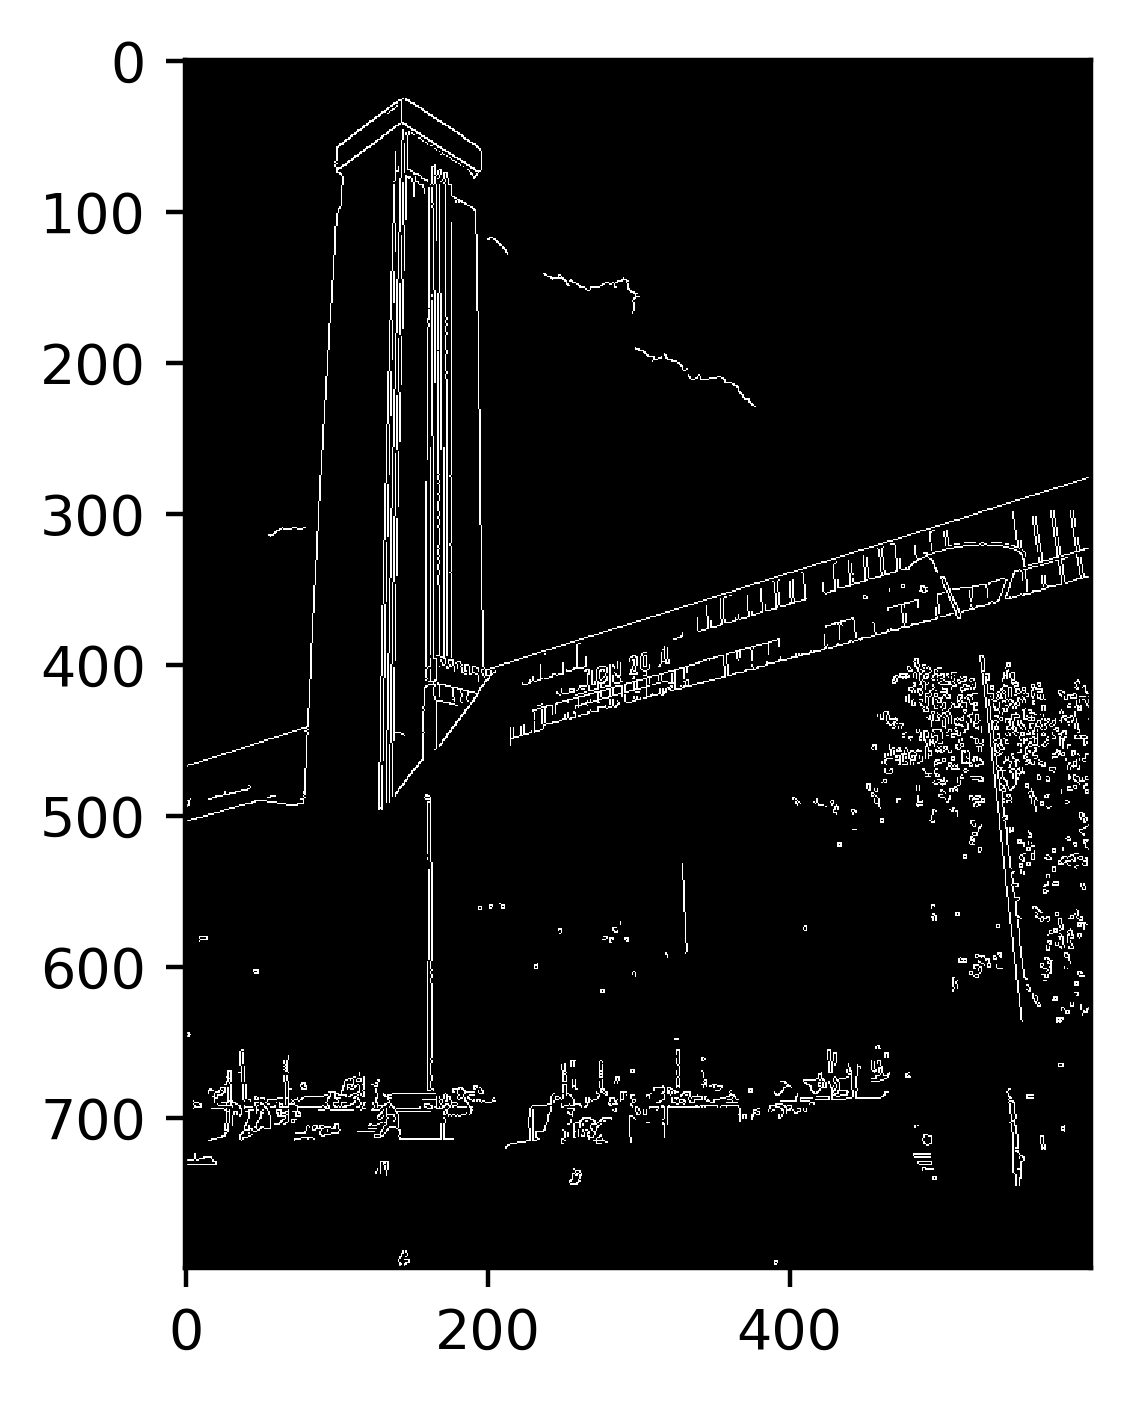

In [61]:
# the two values are the thresholds for the hysteresis
# the bigger the difference between the threshold, the more edges (noise) get detected
edges = cv2.Canny(image, 100, 200)
plt.imshow(edges, cmap='gray')

### Aufgabe2:  Canny Filter auf verschiedenen Auflösungsstufen

Der in OpenCV implementierte Canny Filter erlaubt nicht sehr viele Parameter Angaben, insbesondere ist es nicht möglich ihn direkt auf verschiedenen Auflösungsstufen anzuwenden. Dies können wir aber umgehen, indem wir die Ableitungen selber berechnen.

Dazu wollen wir zuerst das Bild mit einem Gaussfilter glätten und dann davon die ersten Ableitungen in x und y berechnen.

Benutzen Sie dazu die Funktionen GaussianBlur und dann Sobel. Am besten verwenden Sie für die Ableitungen 16bit Integer, die können dann später direkt wieder in der Canny Funktion verwendet werden.

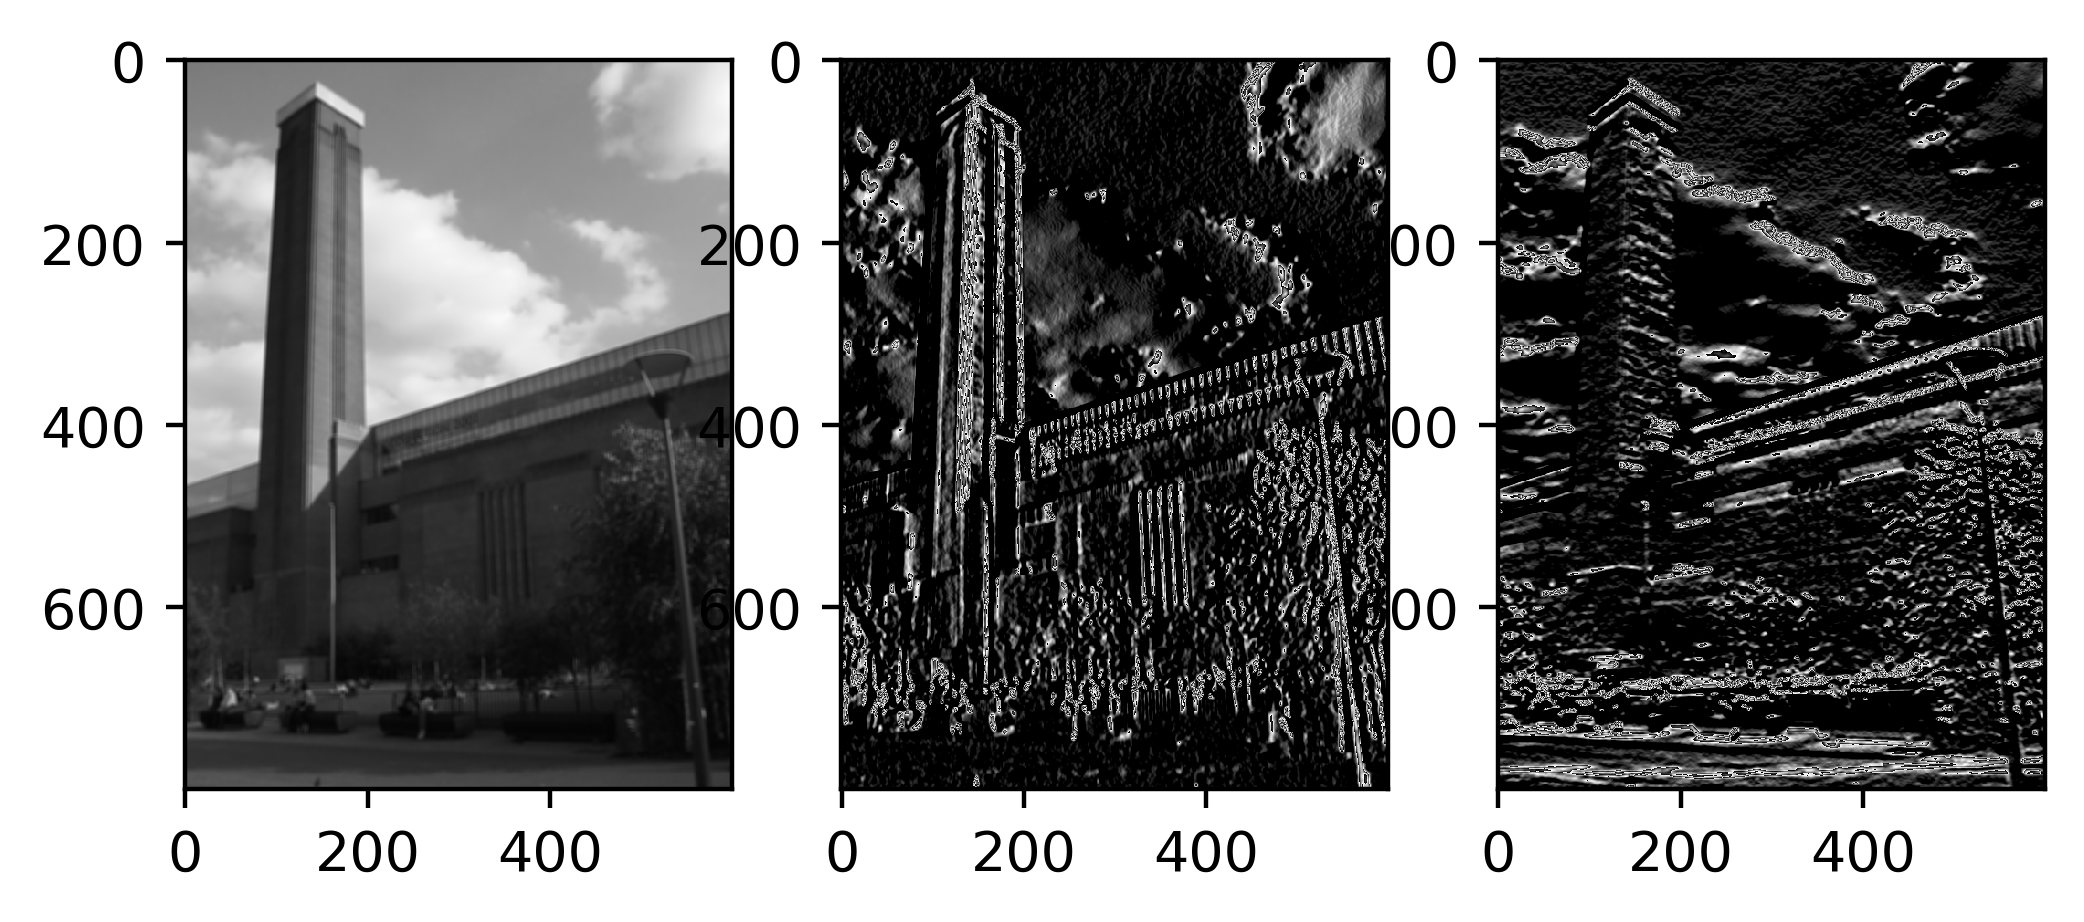

In [116]:
# blur image
blur = cv2.GaussianBlur(image,(5,5), 10)
plt.subplot(1,3,1)
plt.imshow((blur).astype(np.uint8), cmap='gray')

# calculate gradient in x direction
sobel_x = cv2.Sobel(blur,cv2.CV_16U,1,0,ksize=5)
plt.subplot(1,3,2)
plt.imshow((sobel_x).astype(np.uint8), cmap='gray')

# calculate gradient in y direction
sobel_y = cv2.Sobel(blur,cv2.CV_16U,0,1,ksize=5)
plt.subplot(1,3,3)
plt.imshow((sobel_y).astype(np.uint8), cmap='gray')

Stellen Sie dar Resultat der Ableitungen dar (wie?) und berechnen Sie auch die Kantenstärke als 

$$ \text{edge} = \sqrt{dx^2 + dy^2} $$

und stellen Sie diese dar.


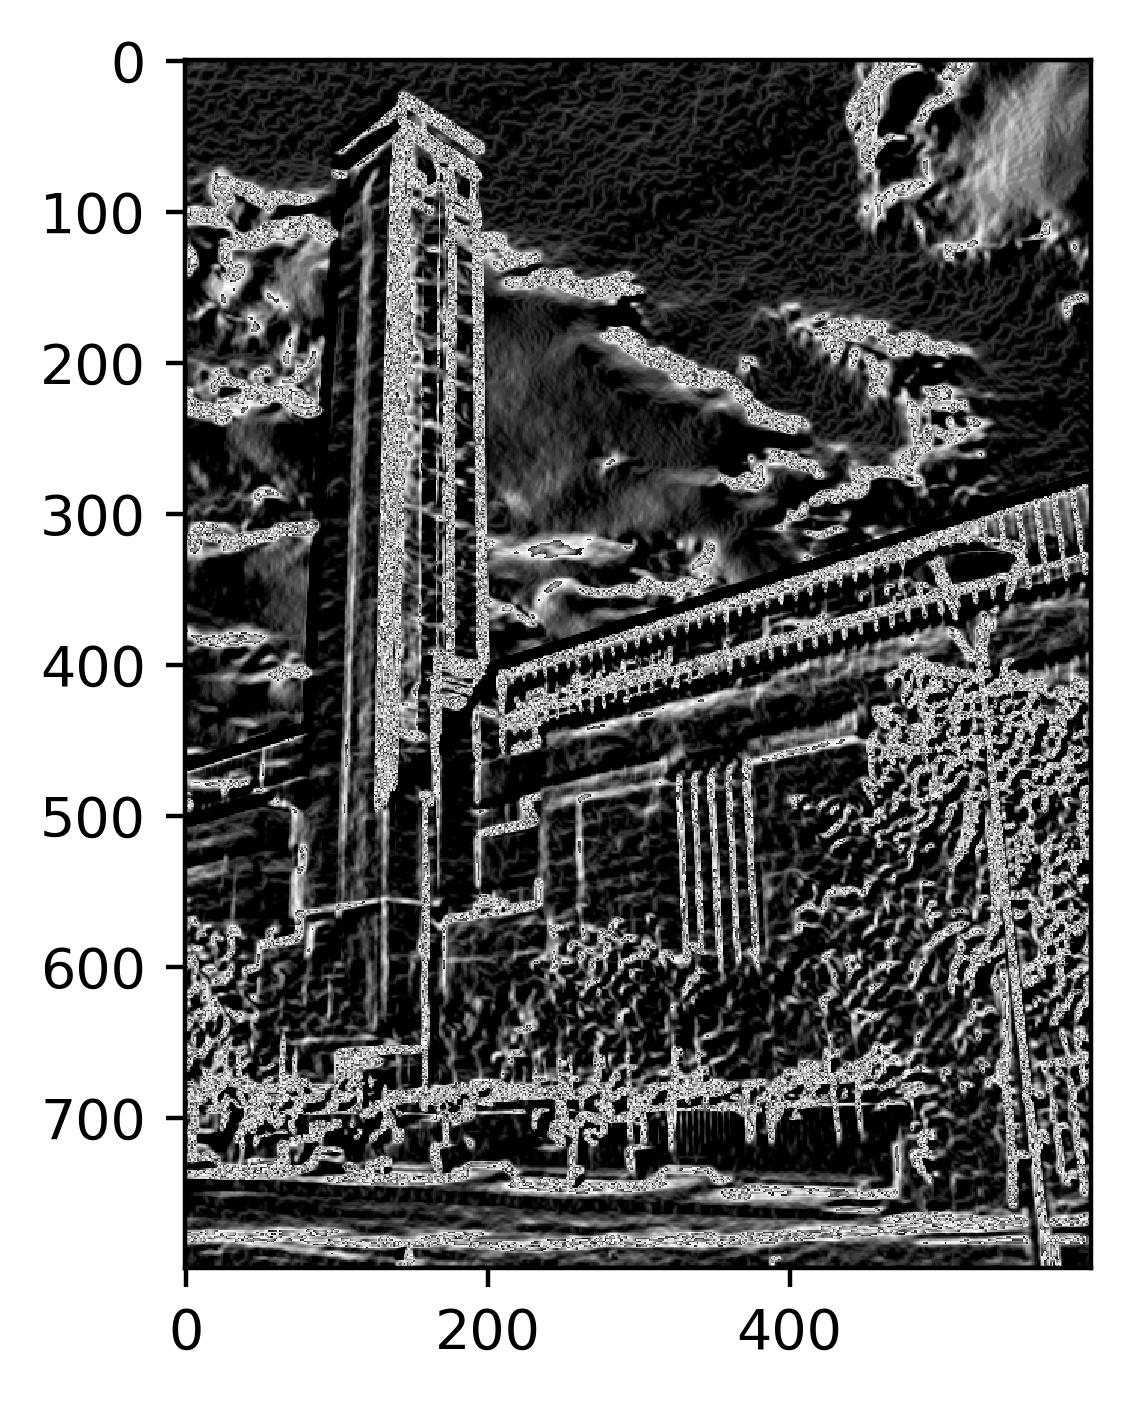

In [117]:
# calculate magnitude of gradients
gradient_mag = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))
plt.imshow((gradient_mag).astype(np.uint8))

Wenden Sie nun nochmals Canny an, aber geben Sie dabei die bereits definierten Ableitungen mit.

Experimentieren Sie mit verschiedenen Werten für das Sigma beim GaussianBlur. Wie wirkt sich der Parameter auf die Kanten aus?

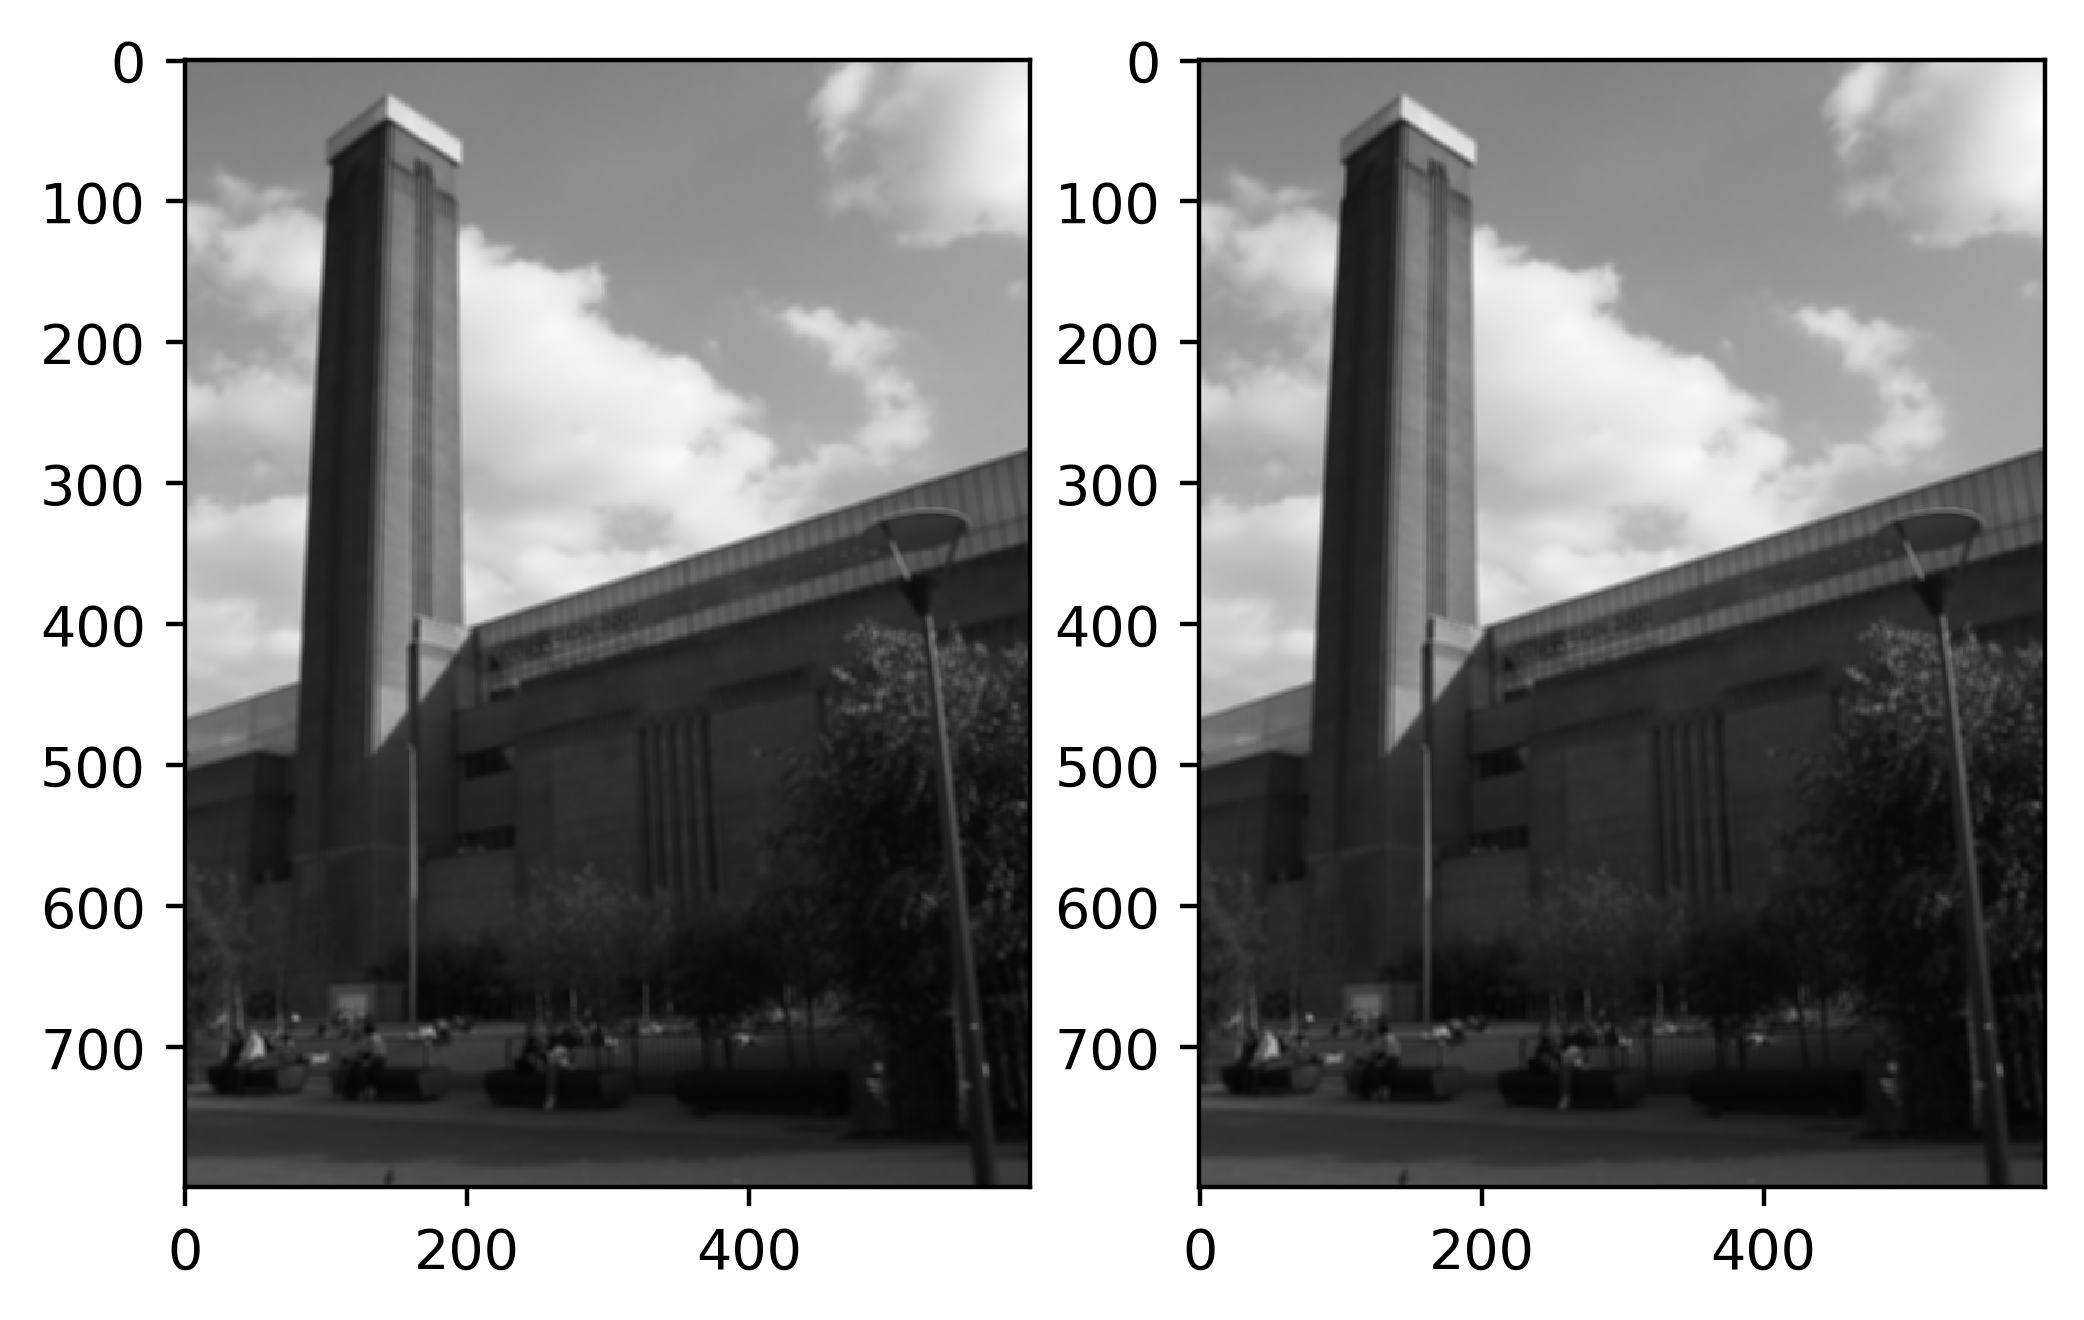

In [118]:
# how can you pass already calculatet gradients to canny?

# the bigger simga, the more 'blurred' the image gets
blur_0 = cv2.GaussianBlur(image,(5,5), 0)
plt.subplot(1,2,1)
plt.imshow(blur, cmap='gray')
           
blur_100 = cv2.GaussianBlur(image,(5,5), 100)
plt.subplot(1,2,2)
plt.imshow(blur_100, cmap='gray')

## Hough Transformation

Die Hough Transformation wirde verwendet um Geraden in einem Bild zu erkennen.

Dafür stehen verschiedene Implementationen zur Verfügung, diejenige in OpenCV ist als cv2.HoughLines verfügbar und berechnet direkt die gefundenen Linien. Diejenige in skimage.transform braucht 2 Schritte mit den Funktionen 'hough_lines' um zuerst den Akkumulator zu berechnen und 'hough_lines_peaks' um die Maxima zu finden. Dafür lässt sich damit der Akkumulator darstellen

Verwenden Sie HoughLines um im Kantenbild die Geraden zu finden und stellen Sie das Ergebnis und den Akkumulator da.

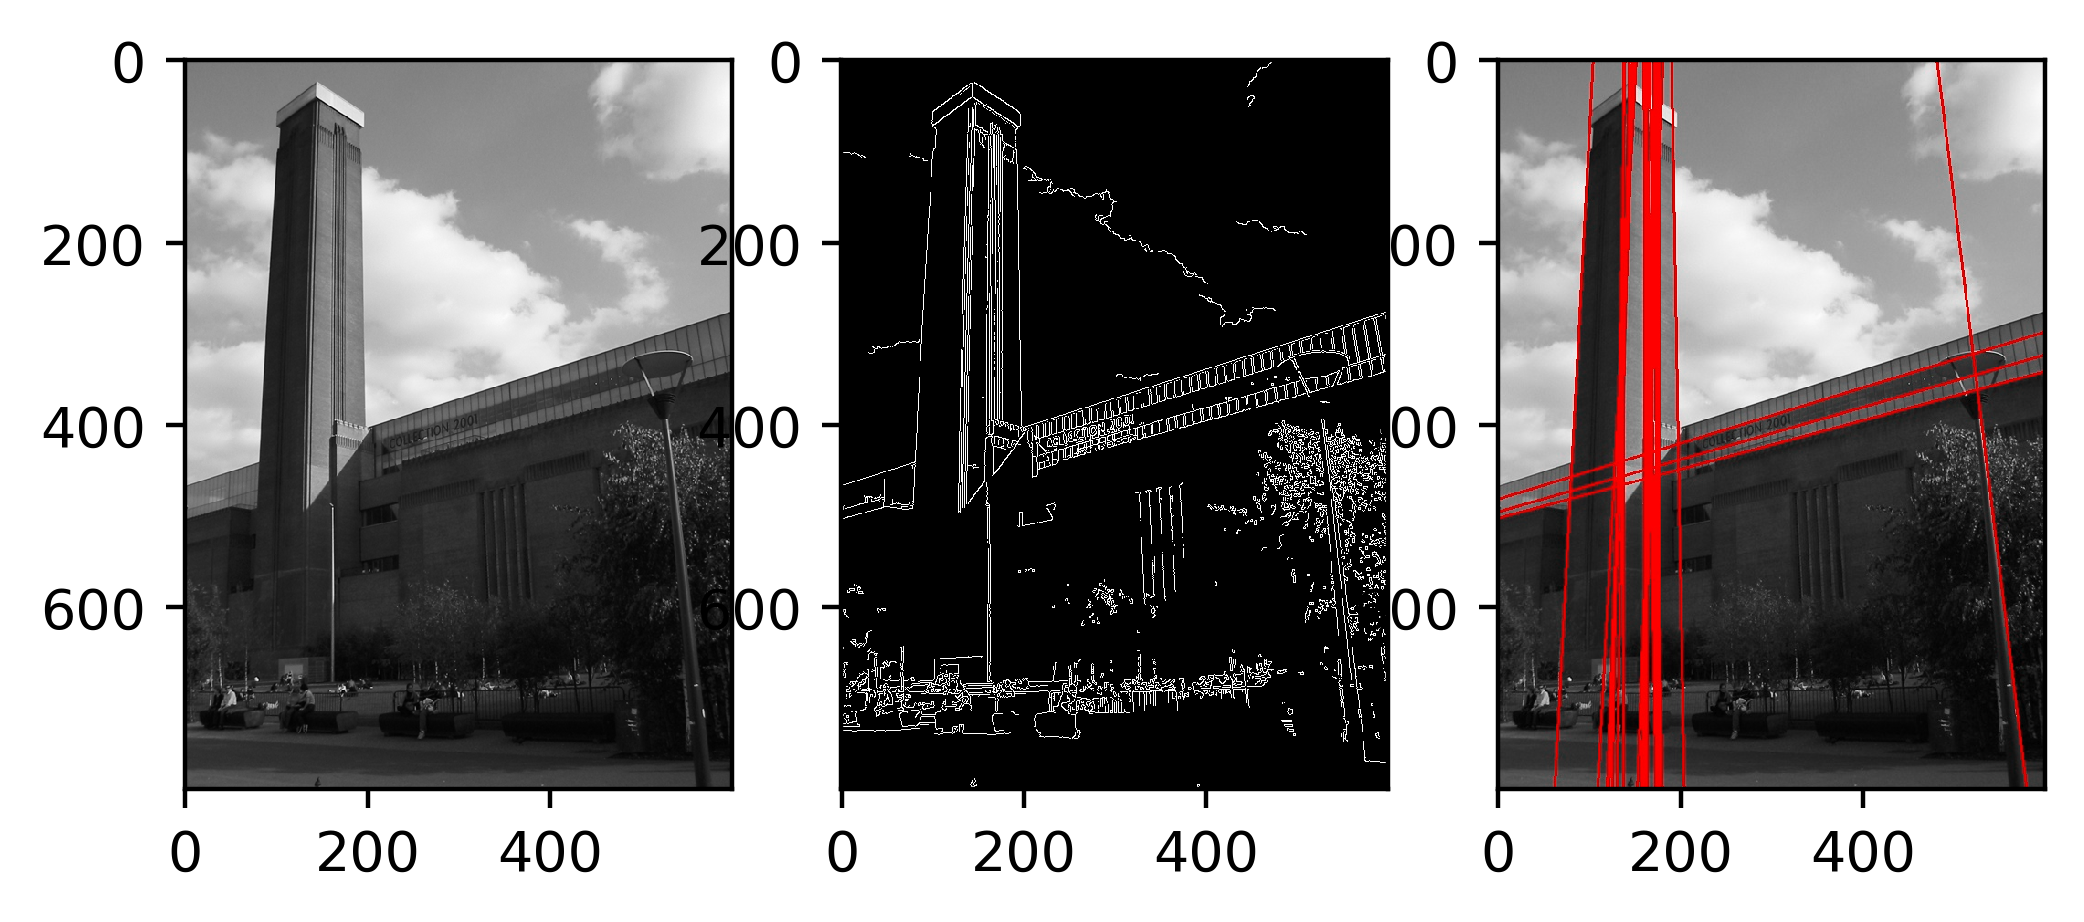

In [12]:
# load image
img = cv2.imread('images/londonSmall.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.subplot(1,3,1)
plt.imshow(img)


# find edges
edges = cv2.Canny(gray,50,150,apertureSize = 3)
plt.subplot(1,3,2)
plt.imshow(edges, cmap='gray')

# find lines
lines = cv2.HoughLines(edges,1,np.pi/180,200)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)
    
cv2.imwrite('images/london_lines.jpg',img)
image_lines = cv2.imread('images/london_lines.jpg')
plt.subplot(1,3,3)
plt.imshow(image_lines)


Stellen Sie die gefundenen Geraden nun auf dem Bild dar. Ein Beispiel dazu finden Sie auf

http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html#sphx-glr-auto-examples-edges-plot-line-hough-transform-py

Sie müssen dazu von den Polarkoordinaten auf kartesische Kooridnaten umrechnen und die zwei Endpunkte der Gerade bestimmen.

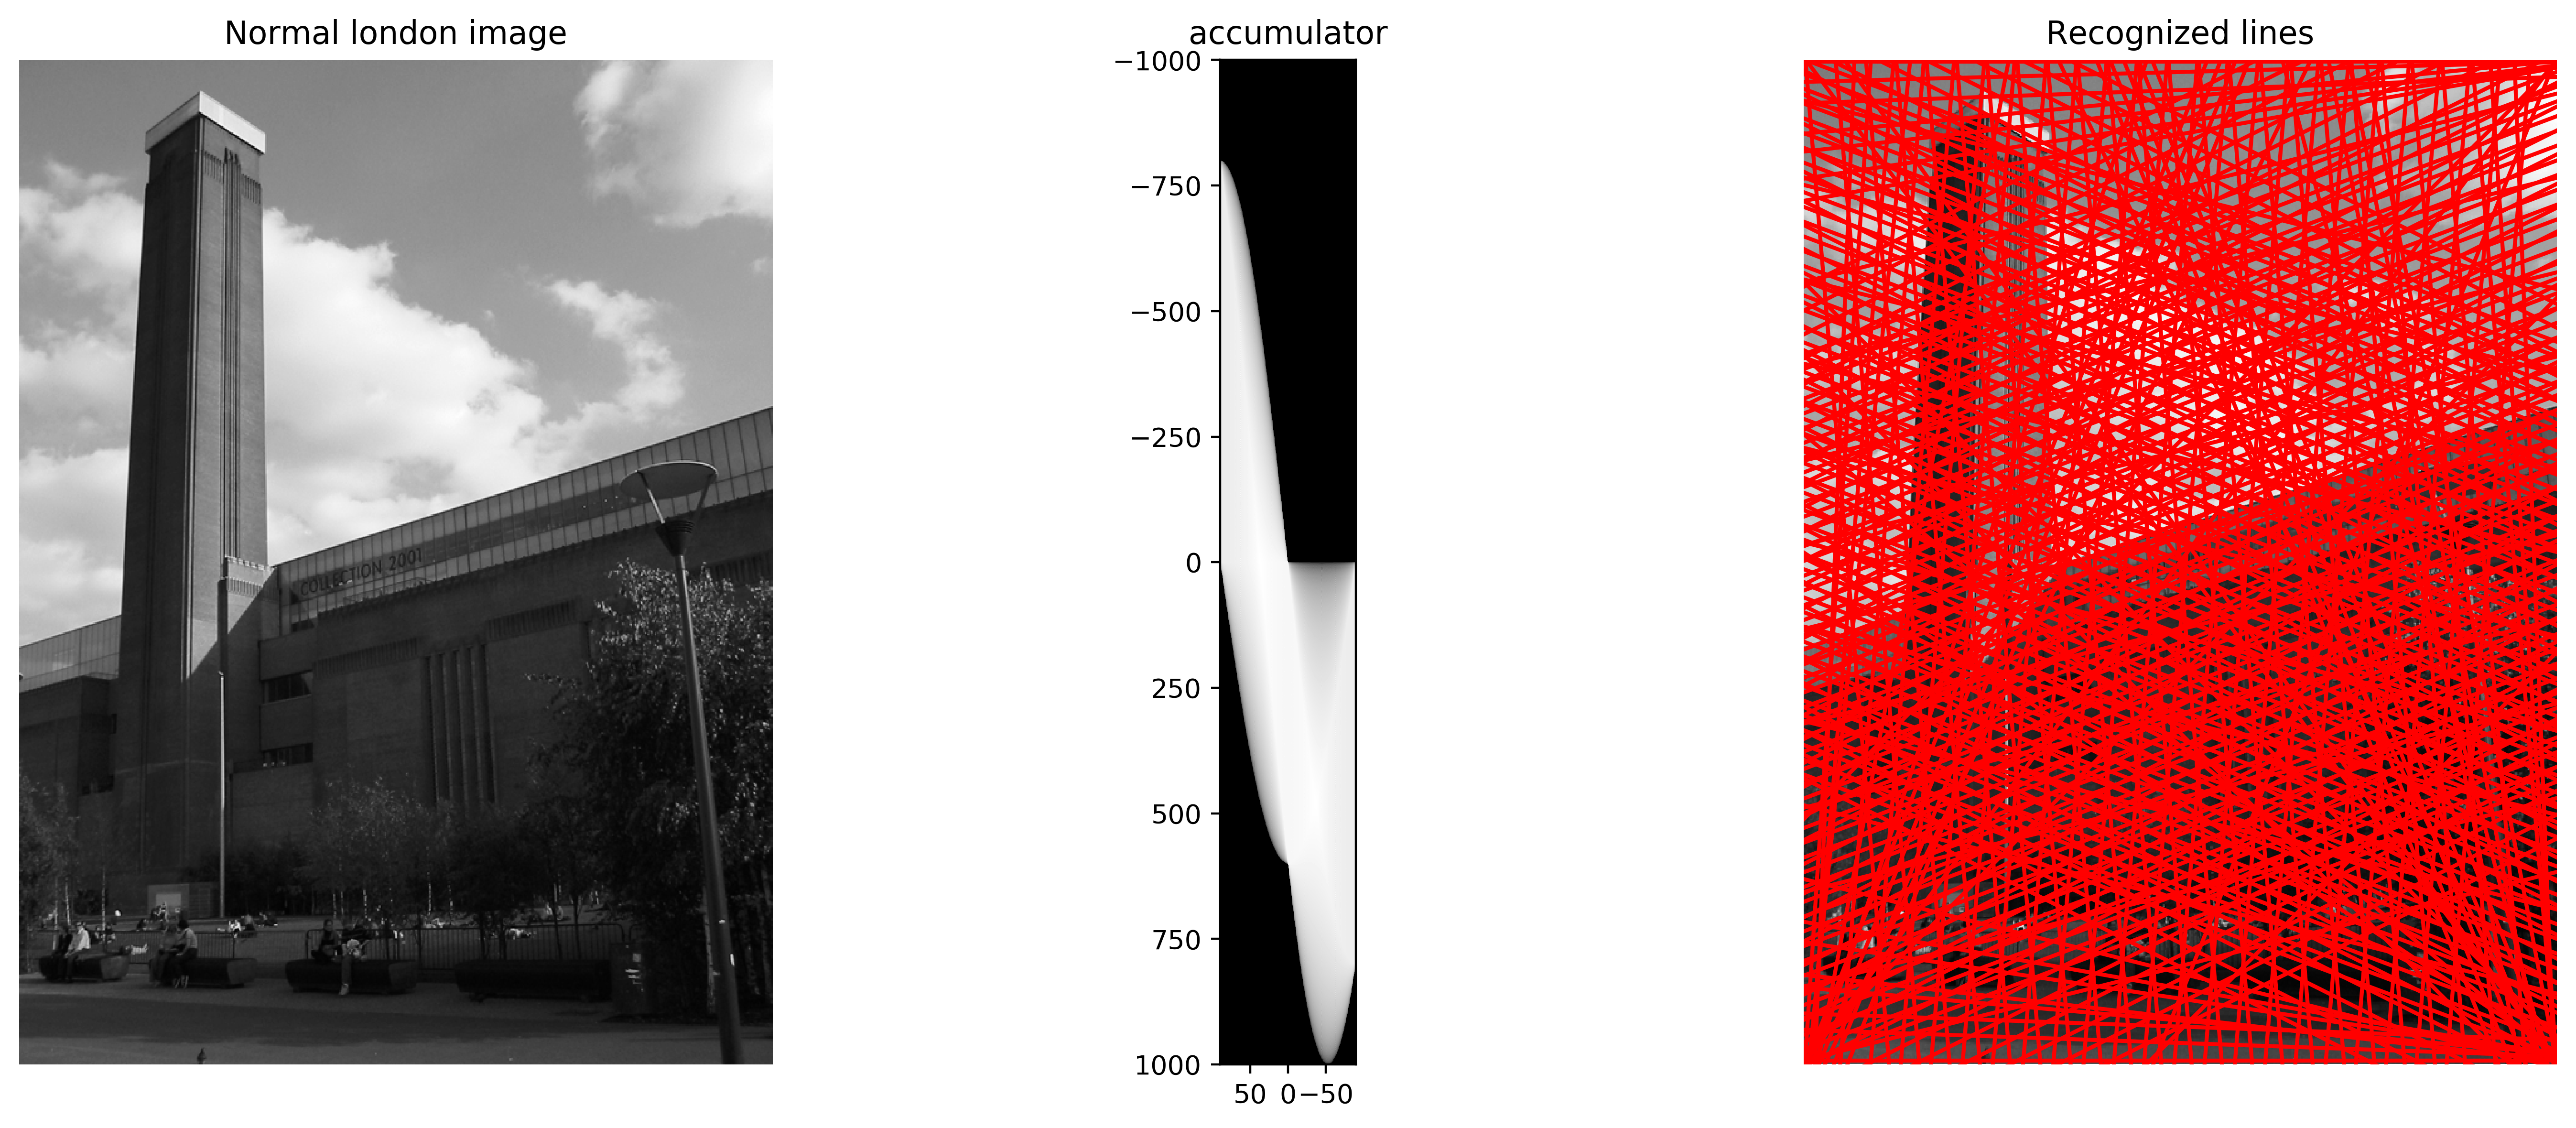

In [18]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

# load image
img = cv2.imread('images/londonSmall.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# perform hough line transform
h, theta, d = hough_line(img)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Normal london image')
ax[0].set_axis_off()

# show accumulator
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('accumulator')

# draw lines
ax[2].imshow(img, cmap=cm.gray)
origin = np.array((0, img.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Recognized lines')

plt.tight_layout()
plt.show()